# Spam email detection using Keras (tensorflow backend)

### Read in & clean text

In [104]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import random
random.seed(47)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Split into train/test

In [105]:
from sklearn.model_selection import train_test_split
random.seed(47)

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

### Vectorize text

In [106]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# Convert label ham to 0 and spam to 1
labels_num = {'ham': 0, 'spam': 1}
y_train = y_train.map(labels_num)
y_test = y_test.map(labels_num)

# Subset data
#X_train_vect = X_train_vect.iloc[1:1000,0:7025]
#X_test_vect = X_test_vect.iloc[1:1000,0:7025]
#y_train = y_train[1:1000]
#y_test = y_test[1:1000]
print(y_train)

print(X_train_vect.shape)
print(y_train)
X_train_vect.head()

4746    0
4171    0
4990    0
4349    0
1198    0
       ..
3189    0
2223    0
1281    0
1110    0
669     0
Name: label, Length: 4453, dtype: int64
(4453, 7222)
4746    0
4171    0
4990    0
4349    0
1198    0
       ..
3189    0
2223    0
1281    0
1110    0
669     0
Name: label, Length: 4453, dtype: int64


,body_len,punct%,0,1,2,3,4,5,6,7,...,7210,7211,7212,7213,7214,7215,7216,7217,7218,7219
0,77,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58,5.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,129,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
X_train_vect.to_csv('train_features.csv', index=False)
X_test_vect.to_csv('test_features.csv', index=False)

y_train.to_csv('train_labels.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

### Final evaluation of models

In [108]:
import joblib
import pandas as pd
from sklearn.model_selection import GridSearchCV
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

X = pd.read_csv('train_features.csv')
Y = pd.read_csv('train_labels.csv')
X

,body_len,punct%,0,1,2,3,4,5,6,7,...,7210,7211,7212,7213,7214,7215,7216,7217,7218,7219
0,77,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58,5.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,129,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,54,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4449,27,14.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4450,34,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4451,51,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
print(Y.label.value_counts())
weights = {0:0.5, 1:0.5}

0    3840
1     613
Name: label, dtype: int64


## Keras with tenserflow

### Load model

In [110]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

dir(KerasClassifier)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'check_params',
 'filter_sk_params',
 'fit',
 'get_params',
 'predict',
 'predict_proba',
 'score',
 'set_params']

In [111]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [112]:
def build_model():
    model = Sequential()
    model.add(Dense(125, input_dim=X.shape[1], activation='relu', name='layer_1'))
    model.add(Dense(250, activation='relu', name='layer_2'))
    #model.add(Dense(500, activation='relu', name='layer_3'))
    model.add(Dense(1, activation='sigmoid', name='output_layer'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [113]:
## Fit Model
from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(X, Y, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
4453/4453 [==============================] - 2s 445us/step - loss: 0.4127 - accuracy: 0.8639
Epoch 2/5
4453/4453 [==============================] - 2s 416us/step - loss: 0.2326 - accuracy: 0.9185
Epoch 3/5
4453/4453 [==============================] - 2s 360us/step - loss: 0.0966 - accuracy: 0.9733
Epoch 4/5
4453/4453 [==============================] - 2s 420us/step - loss: 0.0502 - accuracy: 0.9874
Epoch 5/5
4453/4453 [==============================] - 2s 413us/step - loss: 0.0289 - accuracy: 0.9924


## Validation

### Read data

In [114]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

X_test = pd.read_csv('test_features.csv')
Y_test = pd.read_csv('test_labels.csv')
X_test

,body_len,punct%,0,1,2,3,4,5,6,7,...,7210,7211,7212,7213,7214,7215,7216,7217,7218,7219
0,23,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,60,16.7,0.208204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,351,6.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,88,1.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,111,7.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,35,5.7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1110,39,2.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1111,112,9.8,0.124126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1112,127,2.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### ROC curve

In [115]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(y_pred_keras)

[9.2154741e-04 1.6606708e-05 2.3847818e-04 ... 2.2628725e-02 9.9810117e-01
 8.7797048e-04]


### Random Forest from Sklearn

In [120]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight=weights)
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5, n_jobs=-1)
random.seed(47)
cv.fit(X, Y.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 250}

0.866 (+/-0.007) for {'max_depth': 2, 'n_estimators': 5}
0.862 (+/-0.001) for {'max_depth': 2, 'n_estimators': 50}
0.862 (+/-0.001) for {'max_depth': 2, 'n_estimators': 250}
0.87 (+/-0.006) for {'max_depth': 4, 'n_estimators': 5}
0.862 (+/-0.001) for {'max_depth': 4, 'n_estimators': 50}
0.863 (+/-0.002) for {'max_depth': 4, 'n_estimators': 250}
0.892 (+/-0.015) for {'max_depth': 8, 'n_estimators': 5}
0.887 (+/-0.009) for {'max_depth': 8, 'n_estimators': 50}
0.883 (+/-0.008) for {'max_depth': 8, 'n_estimators': 250}
0.932 (+/-0.02) for {'max_depth': 16, 'n_estimators': 5}
0.931 (+/-0.01) for {'max_depth': 16, 'n_estimators': 50}
0.927 (+/-0.014) for {'max_depth': 16, 'n_estimators': 250}
0.956 (+/-0.012) for {'max_depth': 32, 'n_estimators': 5}
0.961 (+/-0.013) for {'max_depth': 32, 'n_estimators': 50}
0.96 (+/-0.015) for {'max_depth': 32, 'n_estimators': 250}
0.968 (+/-0.006) for {'max_depth': None, 'n_estimators': 5}
0.974 (+/-0.0

In [121]:
y_pred_rf = cv.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
print(y_pred_rf)
print(auc_rf, auc_keras)

[0.    0.004 0.044 ... 0.008 0.92  0.004]
0.9941443823626345 0.9958918703486545


### Print ROC curve for Keras and Random Forest

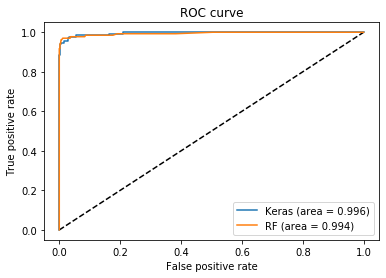

In [122]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

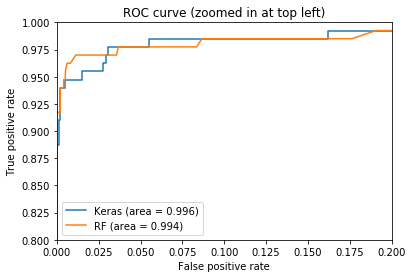

In [123]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()